In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import time

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

SPLIT = int(train_images.shape[0]/2)
VAE_EPOCHS = 15
DIS_C_EPOCHS = 15
GAN_EPOCHS = 100
BATCH_SIZE = 32
LATENT_DIM = 128


gen_data, dis_data = train_images[:SPLIT], train_images[SPLIT:]
gen_y_data, dis_y_data = train_labels[:SPLIT], train_labels[SPLIT:]

gen_dataset = (tf.data.Dataset.from_tensor_slices(gen_data)
                 .shuffle(SPLIT).batch(BATCH_SIZE))
dis_dataset = (tf.data.Dataset.from_tensor_slices(dis_data)
                 .shuffle(SPLIT).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_images.shape[0]).batch(BATCH_SIZE))
dis_classifier_dataset = (tf.data.Dataset.from_tensor_slices((dis_data,dis_y_data))
                 .shuffle(SPLIT).batch(BATCH_SIZE))

In [3]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [4]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
@tf.function
def train_step_dis(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [5]:
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, LATENT_DIM])
gen_vae = CVAE(LATENT_DIM)

In [6]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.show()

In [7]:
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 15, Test set ELBO: -94.46780395507812, time elapse for current epoch: 2.8027141094207764


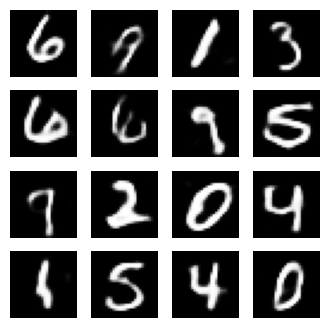

In [8]:
generate_and_save_images(gen_vae, 0, test_sample)

for epoch in range(1, VAE_EPOCHS + 1):
  start_time = time.time()
  for train_x in gen_dataset:
    train_step(gen_vae, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(gen_vae, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(gen_vae, epoch, test_sample)

In [9]:
def get_generator_model(latent_dim):
    return tf.keras.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                    tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                    tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                    tf.keras.layers.Conv2DTranspose(
                        filters=64, kernel_size=3, strides=2, padding='same',
                        activation='relu'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Conv2DTranspose(
                        filters=32, kernel_size=3, strides=2, padding='same',
                        activation='relu'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Conv2DTranspose(
                        filters=1, kernel_size=3, strides=1, padding='same',
                        activation='sigmoid'),
                ]
            )
generator = get_generator_model(LATENT_DIM)

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

discriminator = make_discriminator_model()

In [11]:
def make_discriminator_classifier():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

discriminator_classifier = make_discriminator_classifier()

In [12]:
discriminator_classifier.fit(dis_classifier_dataset,epochs=DIS_C_EPOCHS)

Epoch 1/15
938/938 [==============================] - 6s 4ms/step - loss: 0.2792 - acc: 0.9178
Epoch 2/15
938/938 [==============================] - 3s 3ms/step - loss: 0.1387 - acc: 0.9568
Epoch 3/15
938/938 [==============================] - 3s 3ms/step - loss: 0.1146 - acc: 0.9652
Epoch 4/15
938/938 [==============================] - 4s 4ms/step - loss: 0.1044 - acc: 0.9689
Epoch 5/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0954 - acc: 0.9703
Epoch 6/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0899 - acc: 0.9721
Epoch 7/15
938/938 [==============================] - 4s 4ms/step - loss: 0.0828 - acc: 0.9742
Epoch 8/15
938/938 [==============================] - 3s 4ms/step - loss: 0.0887 - acc: 0.9732
Epoch 9/15
938/938 [==============================] - 3s 3ms/step - loss: 0.0756 - acc: 0.9761
Epoch 10/15
938/938 [==============================] - 4s 4ms/step - loss: 0.0794 - acc: 0.9752
Epoch 11/15
938/938 [============================

In [13]:
def gen_data_loader2(vae, X, y, inp_d, sample_d):
    uy = np.unique(y)
    d = {}
    for i in uy:
        d[i] = X[y  == i]
    while True:
        tgs = np.random.choice(uy,size=inp_d)
        zs = []
        for tg in tgs:
            tg_idxs = np.random.choice(range(d[tg].shape[0]),sample_d,replace=False) 
            d_ = d[tg][tg_idxs]
            mean, logvar = vae.encode(d_)
            z = vae.reparameterize(tf.reduce_mean(mean,axis=0), tf.reduce_mean(logvar,axis=0))
            zs.append(z)
        yield tf.stack(zs), tgs
        
gen_data_g2 = gen_data_loader2(gen_vae, gen_data,gen_y_data,BATCH_SIZE, 16)

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

In [15]:
def generate_images(model, epoch, test_input):
    imgs = test_input[0][:16]
    labs = test_input[1][:16]
    predictions = model(imgs, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1).set_title(f'{labs[i]}')
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.show()

In [16]:
@tf.function
def train_step_with_class(images):
    latent_space, orig_labels = next(gen_data_g2)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(latent_space, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        classifier_output = discriminator_classifier(generated_images,training=False)
        
        gen_loss = generator_loss(fake_output)
        gen_loss += sparse_entropy(orig_labels, classifier_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [17]:
def train_with_class(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step_with_class(image_batch)

    display.clear_output(wait=True)
    generate_images(generator,
                             epoch + 1,
                             next(gen_data_g2))

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_images(generator,
                           epochs,
                           next(gen_data_g2))

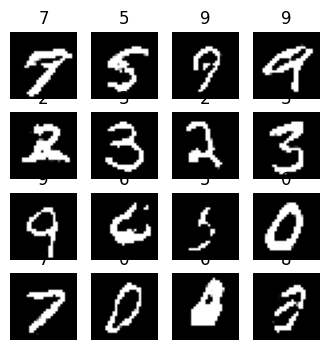

In [18]:
train_with_class(dis_dataset,GAN_EPOCHS)

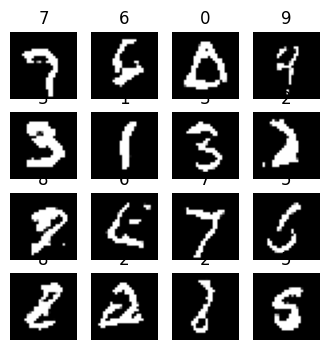

In [19]:
generate_images(generator,
                           0,
                           next(gen_data_g2))

In [20]:
def gen_data_lab(vae, X, y, ratios, sample_d, inp_d):
    uy = np.unique(y)
    d = {}
    for i in uy:
        d[i] = X[y  == i]
    ratios_d = {}
    for k,v in ratios.items():
        ratios_d[k] = round(inp_d*v)
    zs = []
    for tg in ratios_d.keys():
        tg_idxs = np.random.choice(range(d[tg].shape[0]),ratios_d[tg],replace=False) 
        d_ = d[tg][tg_idxs]
        zs.append(d_)
    zs = tf.concat(zs,axis=0)
    mean, logvar = vae.encode(zs)
    idxs = np.random.randint(0,mean.shape[0],size=(sample_d, int(mean.shape[0]/2)))
    mean = tf.gather(mean, idxs, axis=0)
    logvar = tf.gather(logvar, idxs, axis=0) 
    z = vae.reparameterize(tf.reduce_mean(mean,axis=1), tf.reduce_mean(logvar,axis=1))
    return z

outs = gen_data_lab(gen_vae, gen_data,gen_y_data,ratios={1:.25,9:.6,7:.15}, sample_d=16, inp_d = 128)

In [23]:
def generate_gan_images(model, test_input):
    test_input = test_input[:16]
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255., cmap='gray')
        plt.axis('off')

    plt.show()

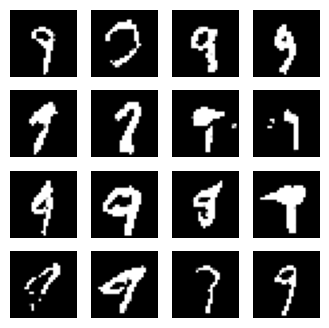

In [25]:
generate_gan_images(generator,outs)

In [ ]:
gen_vae.save_weights("mnist_models/mnist_gen_vae")
generator.save_weights("mnist_models/mnist_generator")
discriminator.save_weights("mnist_models/discriminator")
discriminator_classifier.save_weights("mnist_models/discriminator_classifier")

In [ ]:
!zip -r /content/mnist_models.zip /content/mnist_models

In [ ]:
from google.colab import files
files.download("/content/mnist_models.zip")